# Prophet extension

In [26]:
from ipynb.fs.defs.prophet import generateDistribution, Finv
import pandas as pd
import numpy as np
from tqdm import tqdm # for the progress bar
from statistics import mean
import matplotlib.pyplot as plt
import dataframe_image as dfi
from scipy.stats import ttest_ind

In [2]:
def FairGeneralProphetExtended(q, V, distribution_type, epsilon):
    s = 0.0
    n = len(V)
    for i in range(0,n): #value < 1 reaches a drop!
        p = (1- (q[i]/2)/(epsilon-(s/2)))
        if V[i] >= Finv(distribution_type, p):
            return i
        s += q[i]

def FairIIDProphetExtended(V, distribution_type, epsilon):
    n = len(V)
    for i in range(0, n):
        p = 1 - (2/(3*n)) / (epsilon - 2*(i-1)/(3*n))
        if V[i] >= Finv(distribution_type, p):
                 return i
        
def runExperimentExtended(algorithm, N_experimentReps, distribution_type, n_candidates, epsilon):
    arrivalPositionsChosen, chosenValues, chosenValuesExcludeNone = [0]*n_candidates, [], []
    nones = 0
    for _ in tqdm(range(0, N_experimentReps)):
        q, Values = generateDistribution(distribution_type, n_candidates)
        
        if algorithm == "FairGeneralProphet":
                result = FairGeneralProphetExtended(q, Values, distribution_type, epsilon)
        elif algorithm == "FairIIDProphet":
                result = FairIIDProphetExtended(Values, distribution_type, epsilon)
        if result != None:
            arrivalPositionsChosen[result] += 1
            chosenValues.append(Values[result])
            chosenValuesExcludeNone.append(Values[result])
            
        if result == None: 
            chosenValues.append(0)
            nones += 1     
        
    noneRate = nones/N_experimentReps
        
    return noneRate, mean(chosenValues), mean(chosenValuesExcludeNone), arrivalPositionsChosen

100%|██████████| 50000/50000 [00:05<00:00, 9806.70it/s] 


,epsilon,None rate,Mean value (None=0),Mean value (excluding None)
0,0.25,0.00000,0.923589,0.923589
1,0.50,0.00000,0.955025,0.955025
2,0.75,0.33708,0.655749,0.989183
3,1.00,0.50080,0.495764,0.993117
4,1.25,0.59954,0.398416,0.994895


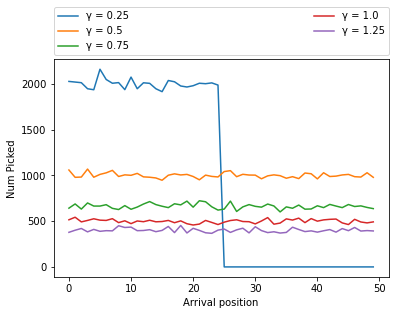

In [13]:
#Fair general prophet Uniform distribution
df = pd.DataFrame(columns=['epsilon', 'None rate', "Mean value (None=0)", "Mean value (excluding None)"])
for param in np.arange(0.25, 1.5, .25):
    nonerate, avg_include, avg_exclude, chosen_positions = runExperimentExtended(algorithm="FairGeneralProphet", 
                                                                                 N_experimentReps=50000,
                                                                                 distribution_type="uniform", 
                                                                                 n_candidates=50, 
                                                                                 epsilon=param
                                                                                )
    
    a_series = pd.Series([param,nonerate,avg_include,avg_exclude], index = df.columns)
    df = df.append(a_series, ignore_index=True)

    plt.plot(range(0,50), chosen_positions, label= str("γ = " + str(param)))
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
plt.savefig("images/extensionFairPA_uniform.png")
dfi.export(df, 'images/extensionFairPA_table_uniform.png')
df

In [5]:
df

,epsilon,None rate,Mean value (None=0),Mean value (excluding None)
0,0.30,0.00000,0.933174,0.933174
1,0.55,0.08986,0.889360,0.977168
2,0.80,0.37360,0.620290,0.990246
3,1.05,0.52288,0.474033,0.993531


100%|██████████| 50/50 [00:06<00:00,  7.28it/s]
/Users/pimpraat/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


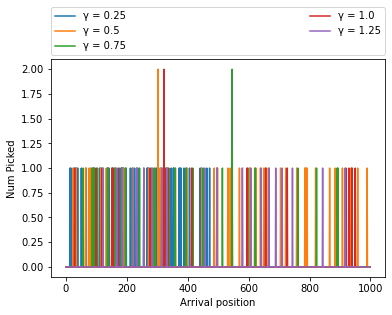

In [28]:
#Fair general prophet Binomial distribution
all_data = []

df = pd.DataFrame(columns=['epsilon', 'None rate', "Mean value (None=0)", "Mean value (excluding None)"])

for param in np.arange(0.25, 1.5, .25): 
    nonerate, avg_include, avg_exclude, chosen_positions = runExperimentExtended(algorithm="FairGeneralProphet", 
                                                                                 N_experimentReps=50000,
                                                                                 distribution_type="binomial", 
                                                                                 n_candidates=1000, 
                                                                                 epsilon=param
                                                                                )
    all_data.append([param, nonerate, avg_include, avg_exclude, chosen_positions])
    a_series = pd.Series([param,nonerate,avg_include,avg_exclude], index = df.columns)
    df = df.append(a_series, ignore_index=True)

    plt.plot(range(0,1000), chosen_positions, label= str("γ = " + str(param)))
    
np.save("data/extension/FairPA.npy", all_data)
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
plt.savefig("images/extensionFairPA_binomial.png")
dfi.export(df, 'images/extensionFairPA_table_binomial.png')

  2%|▏         | 1185/50000 [00:00<00:04, 11833.82it/s]

0.5


  4%|▍         | 2176/50000 [00:00<00:04, 10977.55it/s]

0.6


  2%|▏         | 1162/50000 [00:00<00:04, 11612.34it/s]

0.7


  2%|▏         | 1098/50000 [00:00<00:04, 10979.15it/s]

0.8


  2%|▏         | 840/50000 [00:00<00:05, 8392.52it/s]

0.9


  2%|▏         | 898/50000 [00:00<00:05, 8978.55it/s]

1.0


  3%|▎         | 1723/50000 [00:00<00:05, 8804.49it/s]

1.1


100%|██████████| 50000/50000 [00:06<00:00, 7981.91it/s] 


1.2


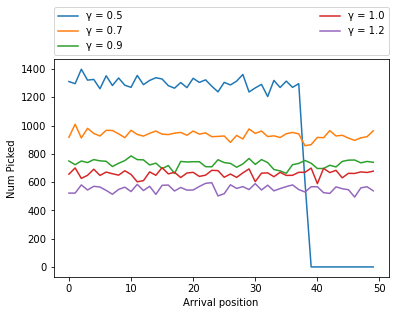

In [22]:
#Fair IID prophet Uniform distribution
df = pd.DataFrame(columns=['epsilon', 'None rate', "Mean value (None=0)", "Mean value (excluding None)"])

for param in np.arange(0.5, 1.3, 0.10):
    param = round(param, 1) #round epsilon in order to deal with float mistake in np.arange generation
    nonerate, avg_include, avg_exclude, chosen_positions = runExperimentExtended(algorithm="FairIIDProphet", 
                                                                                 N_experimentReps=50000,
                                                                                 distribution_type="uniform", 
                                                                                 n_candidates=50, 
                                                                                 epsilon=param
                                                                                )
    
    a_series = pd.Series([param,nonerate,avg_include,avg_exclude], index = df.columns)
    df = df.append(a_series, ignore_index=True)
    
    #For clearity in the plots, we don't plot lines when epsilon is 0.6, 0.8, or 1.1
    if param not in [0.6, 0.8, 1.1]:
        plt.plot(range(0,50), chosen_positions, label= str("γ = " + str(param)))
    
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
plt.savefig("images/extensionFairIID_uniform.png")
dfi.export(df, "images/extensionFairIID_table_uniform.png")

100%|██████████| 50/50 [00:06<00:00,  8.23it/s]


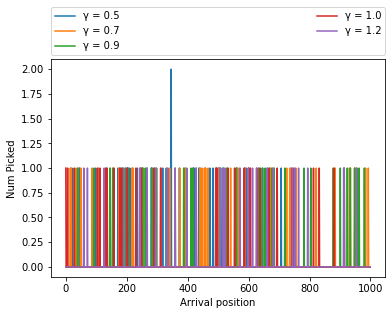

In [29]:
#Fair IID prophet Binomial distribution
all_data = []
df = pd.DataFrame(columns=['epsilon', 'None rate', "Mean value (None=0)", "Mean value (excluding None)"])
for param in np.arange(0.5, 1.3, 0.1):
    param = round(param, 1) #round epsilon in order to deal with float mistake in np.arange generation
    nonerate, avg_include, avg_exclude, chosen_positions = runExperimentExtended(algorithm="FairIIDProphet", 
                                                                                 N_experimentReps=50000,
                                                                                 distribution_type="binomial", 
                                                                                 n_candidates=1000, 
                                                                                 epsilon=param
                                                                                )
    
    a_series = pd.Series([param,nonerate,avg_include,avg_exclude], index = df.columns)
    df = df.append(a_series, ignore_index=True)
    all_data.append([param, nonerate, avg_include, avg_exclude, chosen_positions])
    #For clearity in the plots, we don't plot lines when epsilon is 0.6, 0.8, or 1.1 
    if param not in [0.6, 0.8, 1.1]:
        plt.plot(range(0,1000), chosen_positions, label= str("γ = " + str(param)))

np.save("data/extension/FairIID.npy", all_data)
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
plt.savefig("images/extensionFairIID_binomial.png")
dfi.export(df, "images/extensionFairIID_table_binomial.png")

## Running the significance test for the extension, uniform distribution

_Output is two lists of 10x the avgInclude for the two groups. Group 1 is PaperValue, Group 2 is ourExtensionValue, for both FairProphet and FairIID._

In [36]:
FairProphetPA_PaperValue, FairProphetPA_ExtensionValue = [], []
FairProphetIID_PaperValue, FairProphetIID_ExtensionValue = [], []

FairProphetPA_PaperValue_exclude, FairProphetPA_ExtensionValue_exclude = [], []
FairProphetIID_PaperValue_exclude, FairProphetIID_ExtensionValue_exclude = [], []

FairProphetPA_PaperParameter = 1
FairProphetIID_PaperParameter = 1
FairProphetPA_ExtensionParameter = .5
FairProphetIID_ExtensionParameter = .7

for i in range(0, 10):
    _, avg_include, avg_exclude, _ = runExperimentExtended(algorithm="FairGeneralProphet", 
                                                                                     N_experimentReps=50000,
                                                                                     distribution_type="uniform", 
                                                                                     n_candidates=50, 
                                                                                     epsilon=FairProphetPA_PaperParameter
                                                                                    )
    FairProphetPA_PaperValue.append(avg_include)
    FairProphetPA_PaperValue_exclude.append(avg_exclude)
    
    _, avg_include, avg_exclude, _ = runExperimentExtended(algorithm="FairGeneralProphet", 
                                                                                     N_experimentReps=50000,
                                                                                     distribution_type="uniform", 
                                                                                     n_candidates=50, 
                                                                                     epsilon=FairProphetPA_ExtensionParameter
                                                                                    )
    FairProphetPA_ExtensionValue.append(avg_include)
    FairProphetPA_ExtensionValue_exclude.append(avg_exclude)
    
    
for i in range(0, 10):
    _, avg_include, avg_exclude, _ = runExperimentExtended(algorithm="FairIIDProphet", 
                                                                                     N_experimentReps=50000,
                                                                                     distribution_type="uniform", 
                                                                                     n_candidates=50, 
                                                                                     epsilon=FairProphetIID_PaperParameter
                                                                                    )
    FairProphetIID_PaperValue.append(avg_include)
    FairProphetIID_PaperValue_exclude.append(avg_exclude)
    
    _, avg_include, avg_exclude, _ = runExperimentExtended(algorithm="FairIIDProphet", 
                                                                                     N_experimentReps=50000,
                                                                                     distribution_type="uniform", 
                                                                                     n_candidates=50, 
                                                                                     epsilon=FairProphetIID_ExtensionParameter
                                                                                    )
    FairProphetIID_ExtensionValue.append(avg_include)
    FairProphetIID_ExtensionValue_exclude.append(avg_exclude)
    
    
# FairProphetPA_PaperValue, FairProphetPA_ExtensionValue = [], []
# FairProphetIID_PaperValue, FairProphetIID_ExtensionValue = [], []

# FairProphetPA_PaperValue_exclude, FairProphetPA_ExtensionValue_exclude = [], []
# FairProphetIID_PaperValue_exclude, FairProphetIID_ExtensionValue_exclude = [], []


100%|██████████| 50000/50000 [00:03<00:00, 14537.50it/s]


In [37]:
print(ttest_ind(FairProphetPA_PaperValue, FairProphetPA_ExtensionValue))
print(ttest_ind(FairProphetIID_PaperValue, FairProphetIID_ExtensionValue))

Ttest_indResult(statistic=-472.1633302153419, pvalue=4.533398301206639e-19)
Ttest_indResult(statistic=-377.3909206336682, pvalue=2.721439125806755e-18)


In [38]:
print(ttest_ind(FairProphetPA_PaperValue_exclude, FairProphetPA_ExtensionValue_exclude))
print(ttest_ind(FairProphetIID_PaperValue_exclude, FairProphetIID_ExtensionValue_exclude))

Ttest_indResult(statistic=183.8937345667149, pvalue=8.556826763498086e-16)
Ttest_indResult(statistic=137.54151017547207, pvalue=8.731456368276583e-15)
